In [1]:
import os
import sys
#sys.path.insert(1, '../Src/')

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.decomposition import PCA
from umap import UMAP
from matplotlib import rcParams

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

PATH_DATA = '../../Data/'

%matplotlib inline

In [3]:
fname = "stringer_spontaneous.npy"
fname =os.path.join(PATH_DATA,fname)

In [4]:
# @title Data loading
dat = np.load(fname, allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])



dat has fields:
* `dat['sresp']`: neurons by timebins, a.k.a. the neural response data (11983 by 7018). Timebin = 1.2 sec.
* `dat['run']`: timebins by 1, a.k.a. the running speed of the animal in a.u.
* `dat['xyz']`: three-dimensional position of each neuron in the brain. 
* `dat['pupilArea']`: timebins by 1, see FaceMap for details on the pupil tracker
* `dat['pupilCOM']`: timebins by 2, correspond to X and Y position. See FaceMap for details on the pupil tracker.
* `dat['beh_svd_time']`: timebins by 1,000. Timecourses of behavioral SVDs extracted from face movies. See FaceMap for details. 
* `dat['beh_svd_mask']`: 240 by 320 by 1,000. Spatial masks of behavioral SVDs. Roughly normalized to each other. 
* `dat['beh_svd_mask'] @ dat['beh_svd_time'][T, :]`:  reconstruction of the face movie (its motion energy) for frame T
* `dat['stat']`: 1 by neurons, some statistics for each neuron, see Suite2p for full documentation.

# Neural response

## Sresp Analysis

In [5]:
print(dat['sresp'].shape)
# 11983 neurons
# 7018  trials

print(dat['sresp'][0][:5])
# neuron 0 :  5 trials

(11983, 7018)
[ 2.9820833  8.409119  12.720393   0.         0.       ]


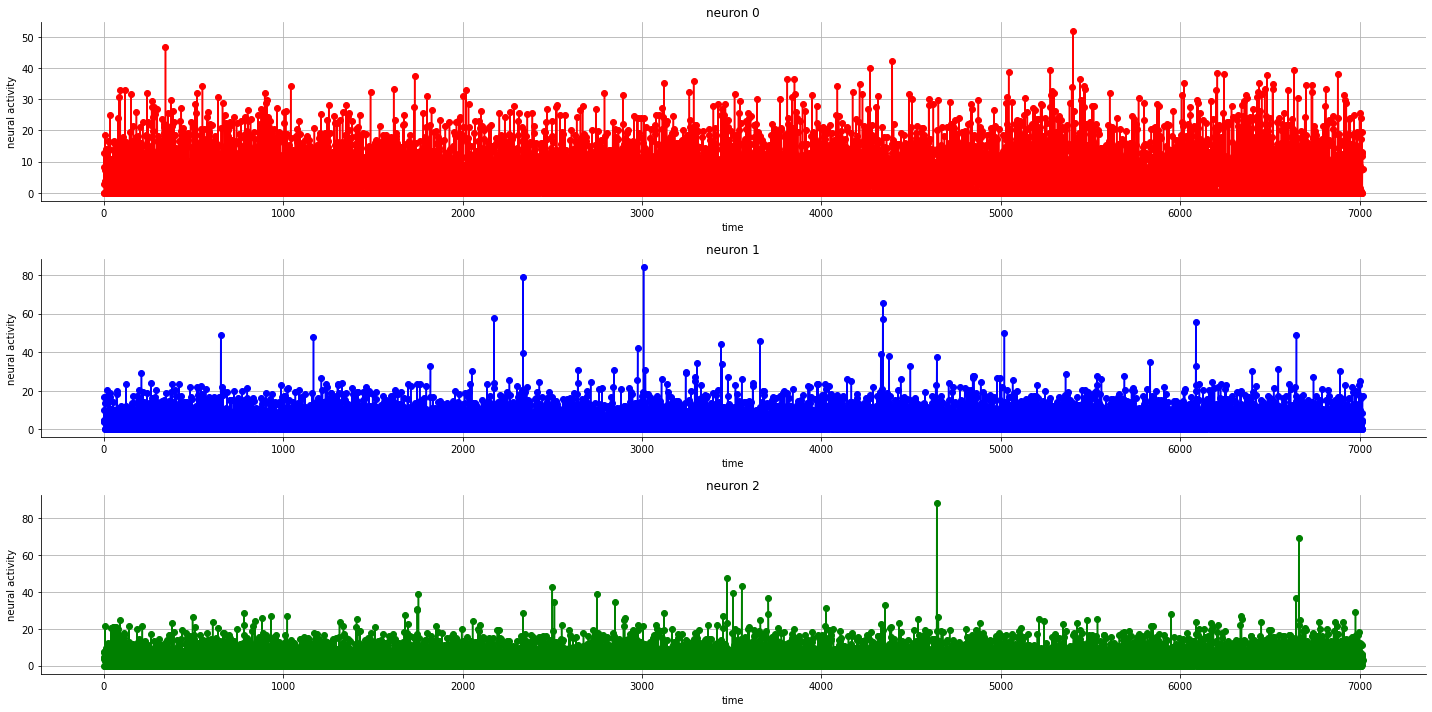

In [41]:
fig, axs = plt.subplots(3, 1,figsize=(20,10))
for idx,color in zip(range(3),['r','b','g']):
    axs[idx].plot(dat['sresp'][idx],'-'+color+'o')
    axs[idx].set_xlabel('time')
    axs[idx].set_ylabel('neural activity')
    axs[idx].set_title('neuron '+str(idx))
    axs[idx].grid(True)

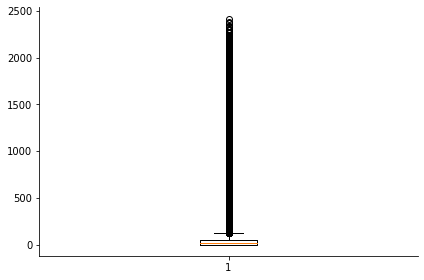

In [13]:
total_sresp = dat['sresp'].flatten()
fig = plt.boxplot(total_sresp)

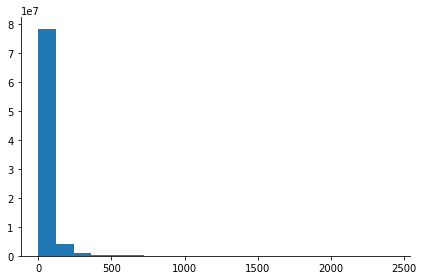

In [14]:
hist = plt.hist(total_sresp,bins=20)

In [179]:
total_sresp_normalized = (total_sresp-total_sresp.mean())/total_sresp.std()

In [181]:
print('mean :',total_sresp.mean())
print('std  :',total_sresp.std())

mean : 39.823605
std  : 81.00055


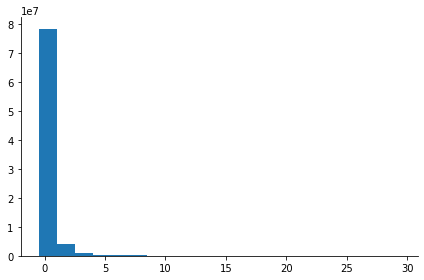

In [180]:
hist = plt.hist(total_sresp_normalized,bins=20)

### Normalization

/media/cristian/Extreme SSD/Investigacion/NMA/nma_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


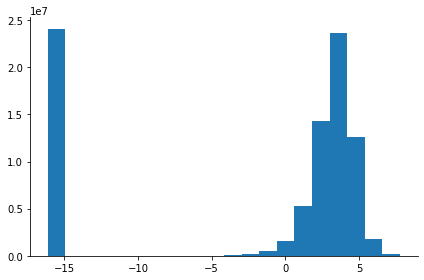

In [184]:
hist = plt.hist(np.log(total_sresp+0.00001),bins=20)

/media/cristian/Extreme SSD/Investigacion/NMA/nma_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


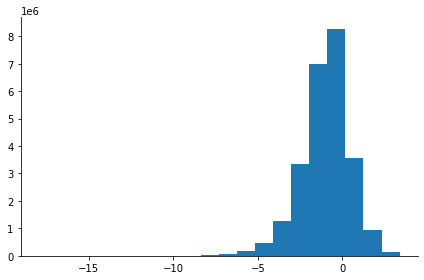

In [185]:
hist = plt.hist(np.log(total_sresp_normalized+0.00001),bins=20)

In [186]:
for percentile in [25,50,75,90,100]:
    print('percentile '+str(percentile)+': ',np.percentile(total_sresp, percentile))

percentile 25:  0.0
percentile 50:  15.809068202972412
percentile 75:  48.536081314086914
percentile 90:  96.9262748718262
percentile 100:  2417.7021484375


In [37]:
maximum_reaction_idx = []
for idx in range(len(dat['sresp'])):
    if dat['sresp'][idx].max()>=2200:
        #print(idx)
        maximum_reaction_idx.append(idx)

In [38]:
maximum_reaction_idx[-6:]

[8229, 10040, 10678, 10956, 11425, 11509]

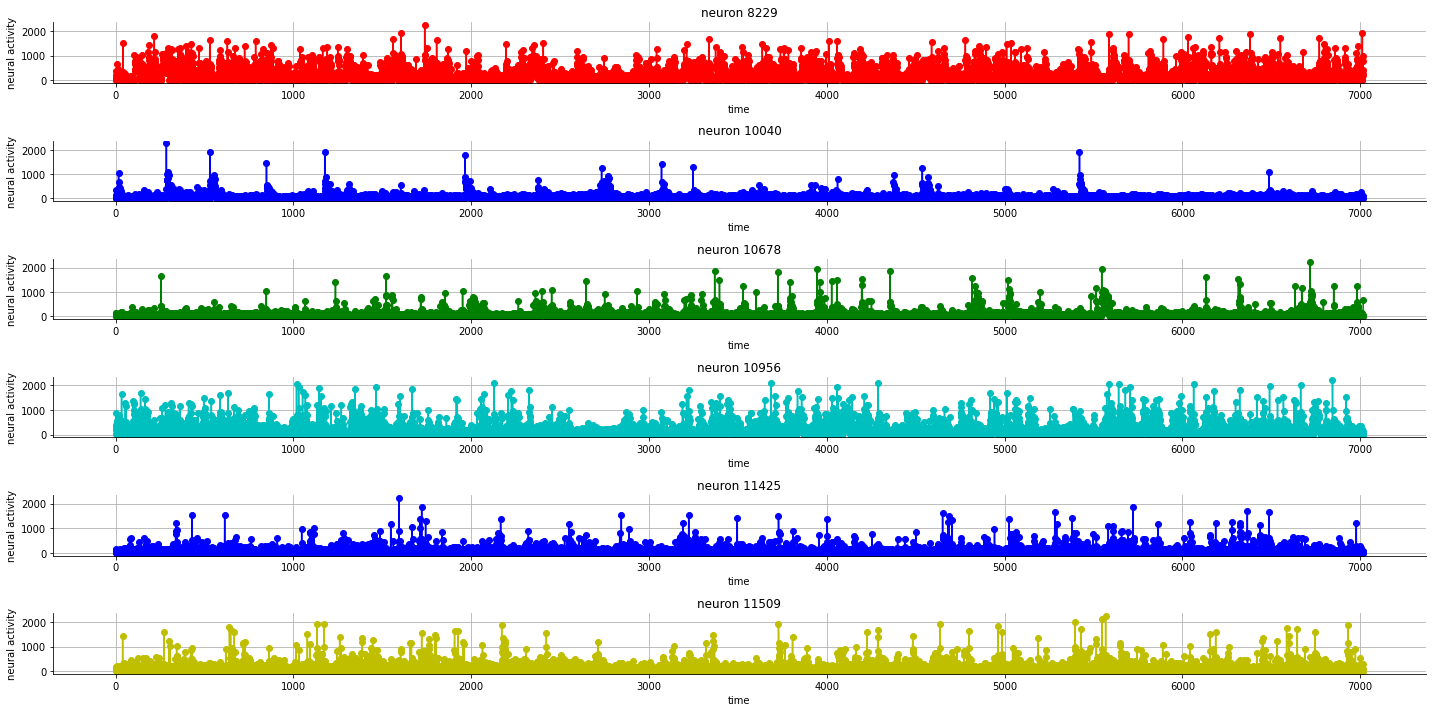

In [39]:
fig, axs = plt.subplots(6, 1,figsize=(20,10))
cnt = 0
for idx,color in zip(maximum_reaction_idx[-6:],['r','b','g','c','b','y']):
    axs[cnt].plot(dat['sresp'][idx],'-'+color+'o')
    axs[cnt].set_xlabel('time')
    axs[cnt].set_ylabel('neural activity')
    axs[cnt].set_title('neuron '+str(idx))
    axs[cnt].grid(True)
    cnt+=1

In [42]:
# calcium imaging?

## XYZ analysis

In [6]:
print(dat['xyz'].shape)
#118983 neurons
#3  xyz

(3, 11983)


In [8]:
%matplotlib qt

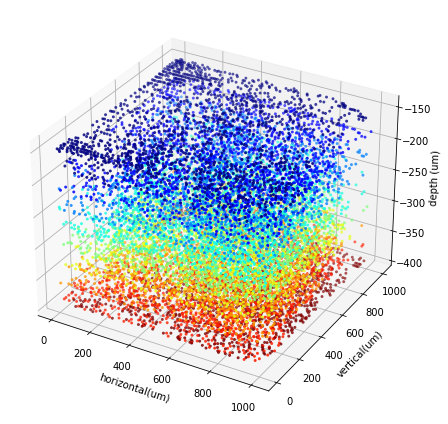

In [59]:
# @title plot the 3D positions of all neurons1
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

x, y, z = dat['xyz']

zunq, iunq = np.unique(z, return_inverse=True)
xc = np.linspace(0.0, 1.0, len(zunq))
cmap = cm.get_cmap('jet')(xc)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[::-1],y[::-1], z[::-1], 'o', s=4, c=cmap[iunq])
ax.set(xlabel='horizontal(um)', ylabel='vertical(um)', zlabel='depth (um)')
plt.show()

In [51]:
dat['sresp'].shape

(11983, 7018)

In [9]:
# @title plot the 3D positions of all neurons with neural activity

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

x, y, z = dat['xyz']
intensity = dat['sresp'][:,0]
#intensity[intensity>96.9262748718262] = 96.9262748718262

zunq, iunq = np.unique(intensity, return_inverse=True)
xc = np.linspace(0.0, 1.0, len(zunq))
cmap = cm.get_cmap('Reds')(xc)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[::-1], y[::-1], z[::-1], 'o', s=4, c=cmap[iunq])
ax.set(xlabel='horizontal(um)', ylabel='vertical(um)', zlabel='depth (um)')
plt.title('Neural activity trial 0')

plt.show()

In [11]:
# @title plot the 3D positions of all neurons with neural activity

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

x, y, z = dat['xyz']
intensity = dat['sresp'][:,7017]
#intensity[intensity>96.9262748718262] = 96.9262748718262

zunq, iunq = np.unique(intensity, return_inverse=True)
xc = np.linspace(0.0, 1.0, len(zunq))
cmap = cm.get_cmap('Reds')(xc)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[::-1], y[::-1], z[::-1], 'o', s=4, c=cmap[iunq])
ax.set(xlabel='horizontal(um)', ylabel='vertical(um)', zlabel='depth (um)')
plt.title('Neural activity trial 7017')
plt.show()

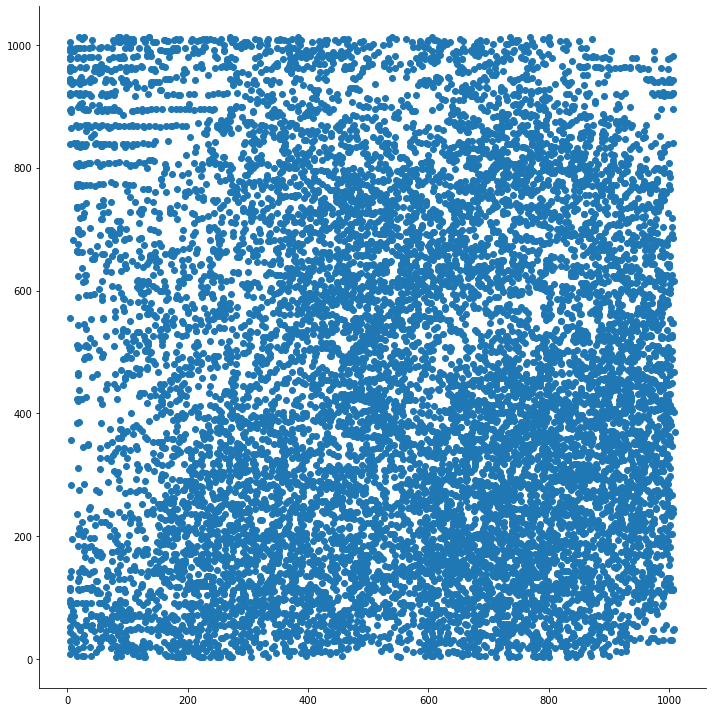

In [65]:
# XY view

x, y, z = dat['xyz']
fig = plt.figure(figsize=(10,10))
plt.plot(x,y,'o')

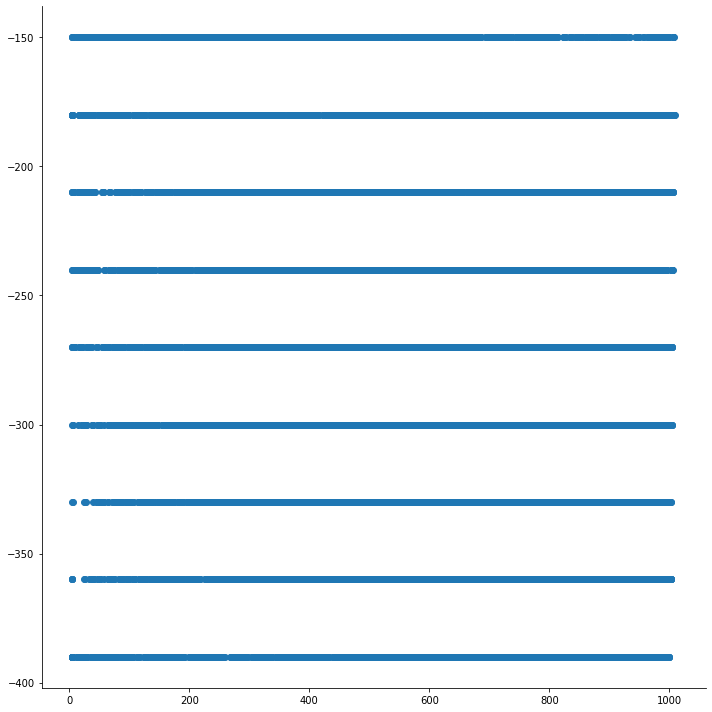

In [66]:
# XZ view

x, y, z = dat['xyz']
fig = plt.figure(figsize=(10,10))
plt.plot(x,z,'o')

In [68]:
np.unique(z) # 9 layers

array([-390., -360., -330., -300., -270., -240., -210., -180., -150.])

## stat analysis 

In [76]:
print(dat['stat'].shape)
print(dat['stat'][0][:5])

(11983, 1)
[(array([[  85],
        [  86],
        [  87],
        [  88],
        [  89],
        [ 590],
        [ 591],
        [ 592],
        [ 593],
        [ 594],
        [1095],
        [1096],
        [1097],
        [1098],
        [1099],
        [1600],
        [1601],
        [1602],
        [1603],
        [1604],
        [2107]], dtype=uint16), array([[85],
        [86],
        [87],
        [88],
        [89],
        [85],
        [86],
        [87],
        [88],
        [89],
        [85],
        [86],
        [87],
        [88],
        [89],
        [85],
        [86],
        [87],
        [88],
        [89],
        [87]], dtype=uint8), array([[1],
        [1],
        [1],
        [1],
        [1],
        [2],
        [2],
        [2],
        [2],
        [2],
        [3],
        [3],
        [3],
        [3],
        [3],
        [4],
        [4],
        [4],
        [4],
        [4],
        [5]], dtype=uint8), array([[0.04830076],
        [0.03870747]

In [84]:
aux  = np.array(dat['stat'][0])
aux.shape

(1,)

In [93]:
len(aux)

1

In [90]:
aux[0].shape

()

In [89]:
len(aux[0])

29

In [91]:
aux[0][0]

array([[  85],
       [  86],
       [  87],
       [  88],
       [  89],
       [ 590],
       [ 591],
       [ 592],
       [ 593],
       [ 594],
       [1095],
       [1096],
       [1097],
       [1098],
       [1099],
       [1600],
       [1601],
       [1602],
       [1603],
       [1604],
       [2107]], dtype=uint16)

In [92]:
aux[0][1]

array([[85],
       [86],
       [87],
       [88],
       [89],
       [85],
       [86],
       [87],
       [88],
       [89],
       [85],
       [86],
       [87],
       [88],
       [89],
       [85],
       [86],
       [87],
       [88],
       [89],
       [87]], dtype=uint8)

# Spontenous Behavior

## Run analysis

In [95]:
print(dat['run'].shape)
# 7018 time bins

(7018, 1)


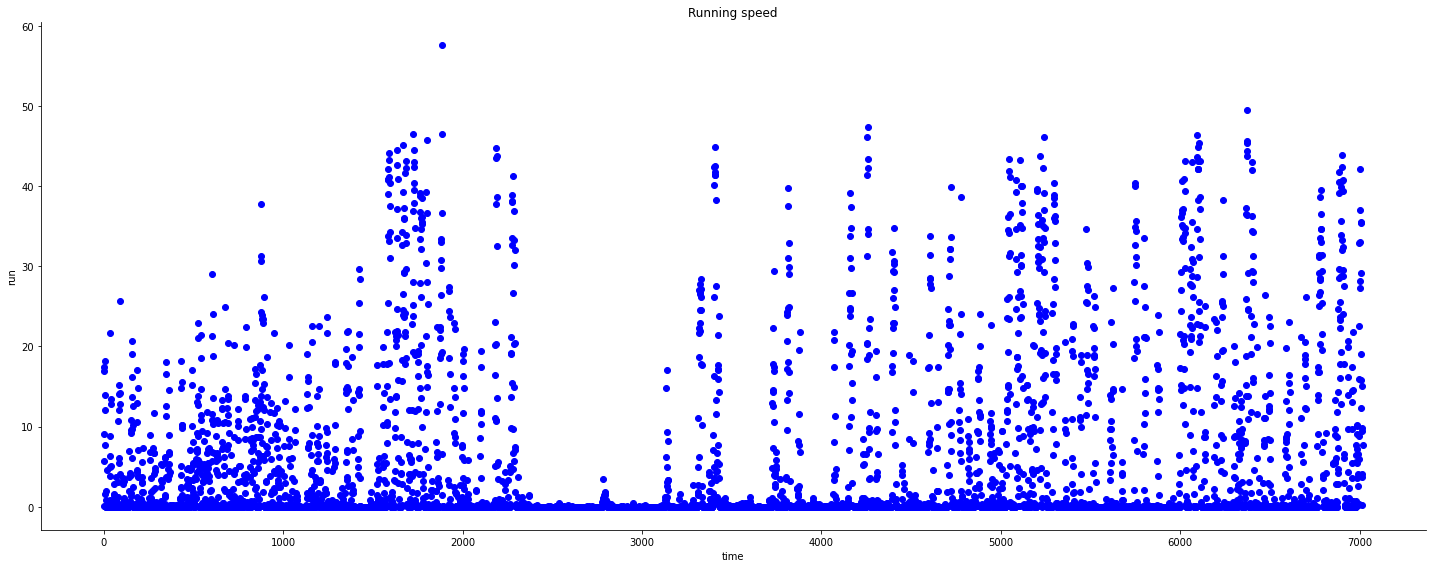

In [108]:
fig = plt.figure(figsize=(20,8))
plt.plot(dat['run'],'bo')
plt.title('Running speed')
plt.xlabel('time')
plt.ylabel('run')

plt.show()

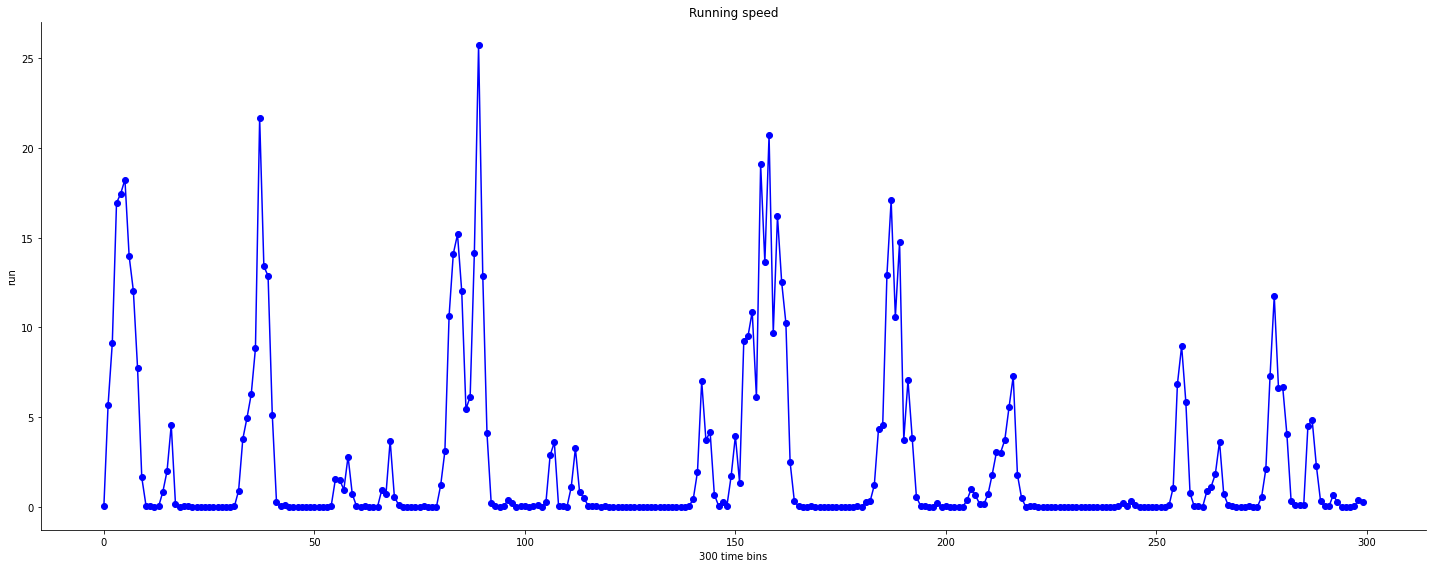

In [112]:
fig = plt.figure(figsize=(20,8))
plt.plot(dat['run'][:300],'-bo')
plt.title('Running speed')
plt.xlabel('300 time bins')
plt.ylabel('run')

plt.show()

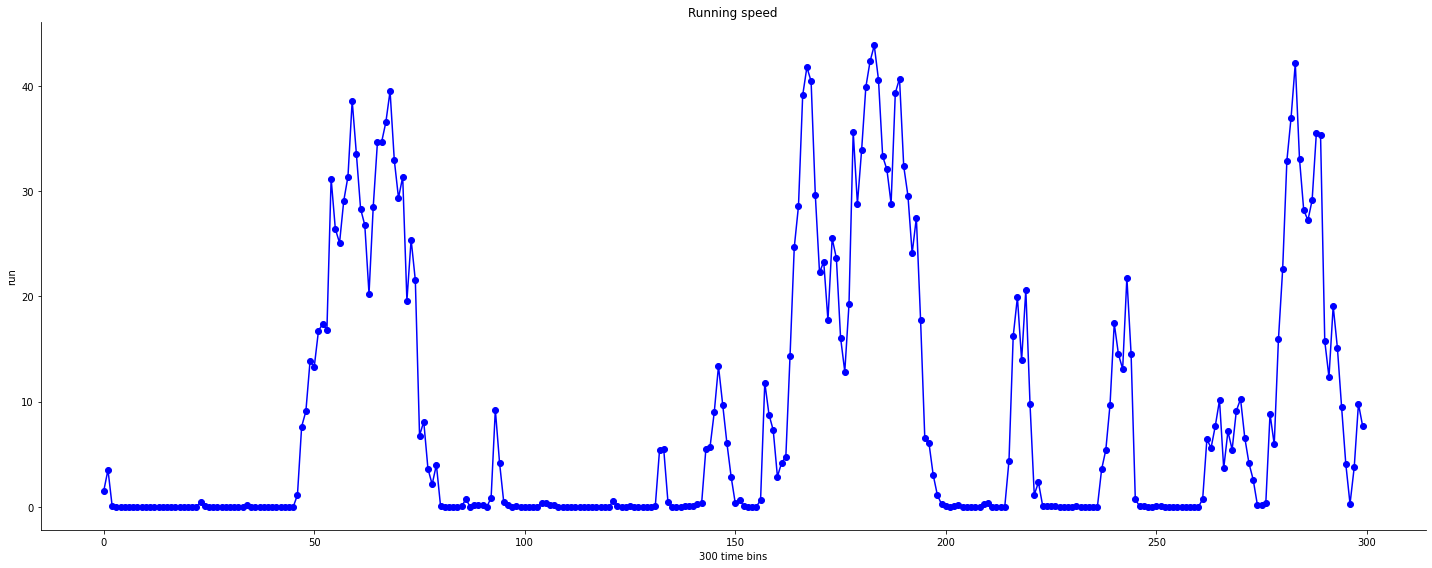

In [113]:
fig = plt.figure(figsize=(20,8))
plt.plot(dat['run'][-300:],'-bo')
plt.title('Running speed')
plt.xlabel('300 time bins')
plt.ylabel('run')

plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x7f23c234d5d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f23c222c1d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f23c234d850>],
 'medians': [<matplotlib.lines.Line2D at 0x7f23c222c690>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f23c222c9d0>],
 'means': []}

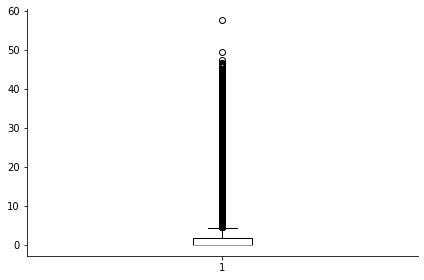

In [103]:
plt.boxplot(dat['run'])

In [104]:
for percentile in [25,50,75,90,100]:
    print('percentile'+str(percentile)+': ',np.percentile(dat['run'], percentile))

percentile25:  0.0
percentile50:  0.018142909318237442
percentile75:  1.748330940573128
percentile90:  16.02818847284595
percentile100:  57.55417351414499


## Run vs Neural activity

In [114]:
run = dat['run']
neural_activity = dat['sresp']

In [116]:
neural_activity.shape

(11983, 7018)

In [119]:
neural_activity_mean = neural_activity.mean(axis=0)
neural_activity_mean.shape

(7018,)

In [120]:
neural_activity_mean

array([29.67313 , 42.625553, 42.60116 , ..., 40.357918, 54.82302 ,
       53.409435], dtype=float32)

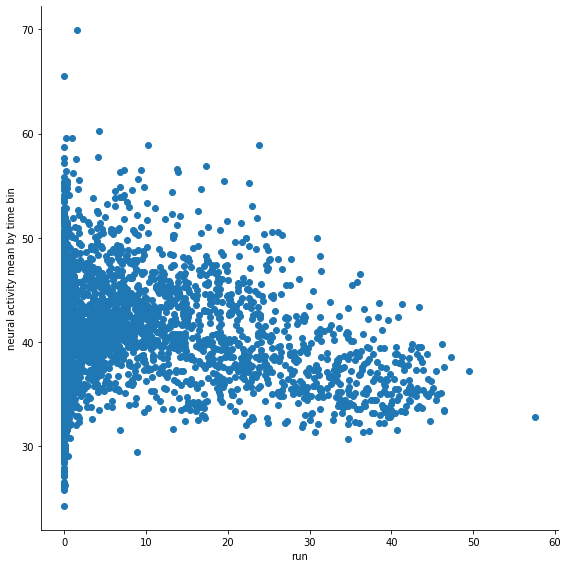

In [124]:
fig = plt.figure(figsize=(8,8))
plt.plot(run,neural_activity_mean,'o')
plt.xlabel('run')
plt.ylabel('neural activity mean by time bin')
plt.show()

In [125]:
neural_activity_max = neural_activity.max(axis=0)
neural_activity_max.shape

(7018,)

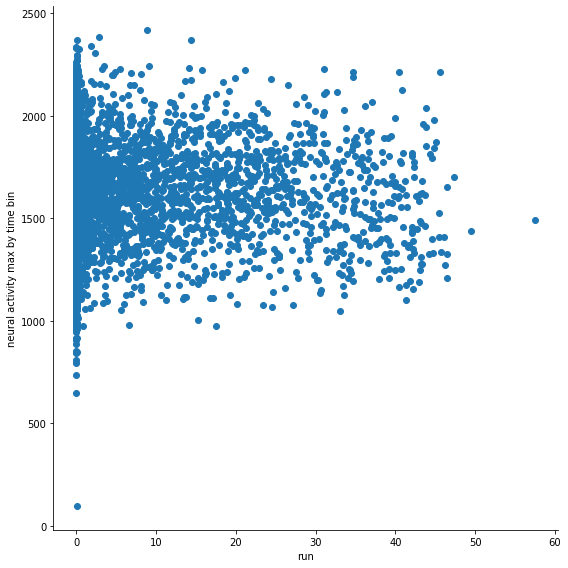

In [126]:
fig = plt.figure(figsize=(8,8))
plt.plot(run,neural_activity_max,'o')
plt.xlabel('run')
plt.ylabel('neural activity max by time bin')
plt.show()

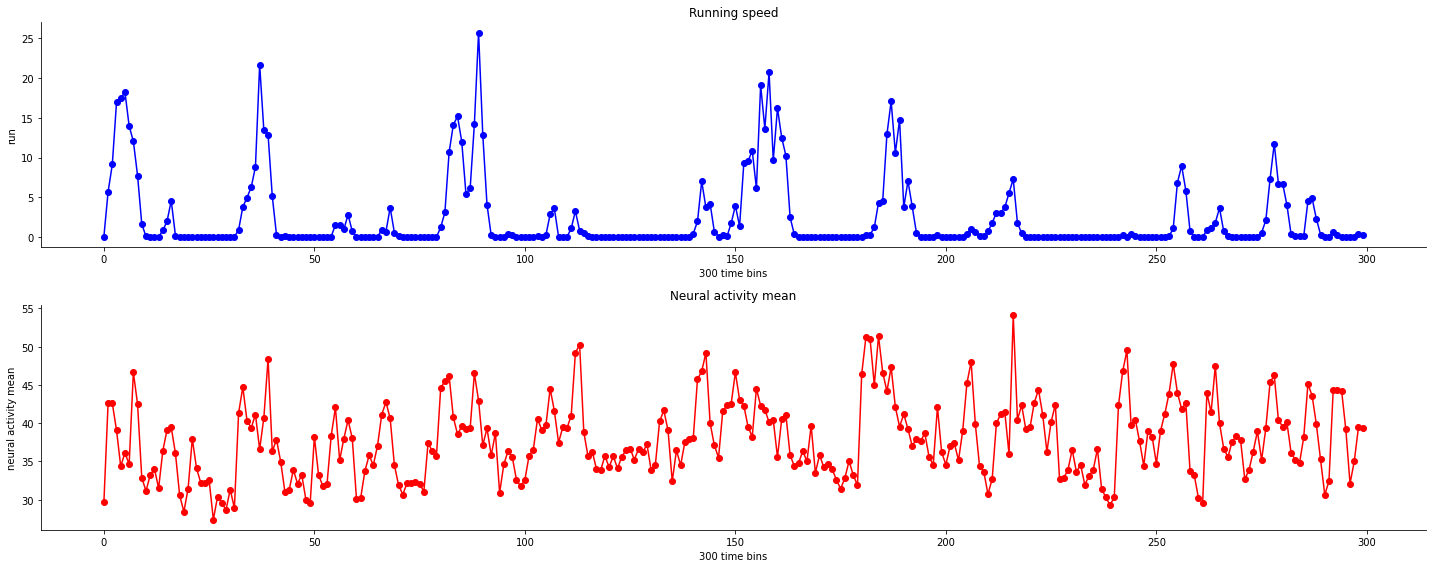

In [149]:
fig = plt.figure(figsize=(20,8))

plt.subplot(2,1,1)
plt.plot(dat['run'][:300],'-bo')
plt.title('Running speed')
plt.xlabel('300 time bins')
plt.ylabel('run')
plt.subplot(2,1,2)
plt.plot(neural_activity_mean[:300],'-ro')
plt.title('Neural activity mean')
plt.xlabel('300 time bins')
plt.ylabel('neural activity mean')


plt.show()

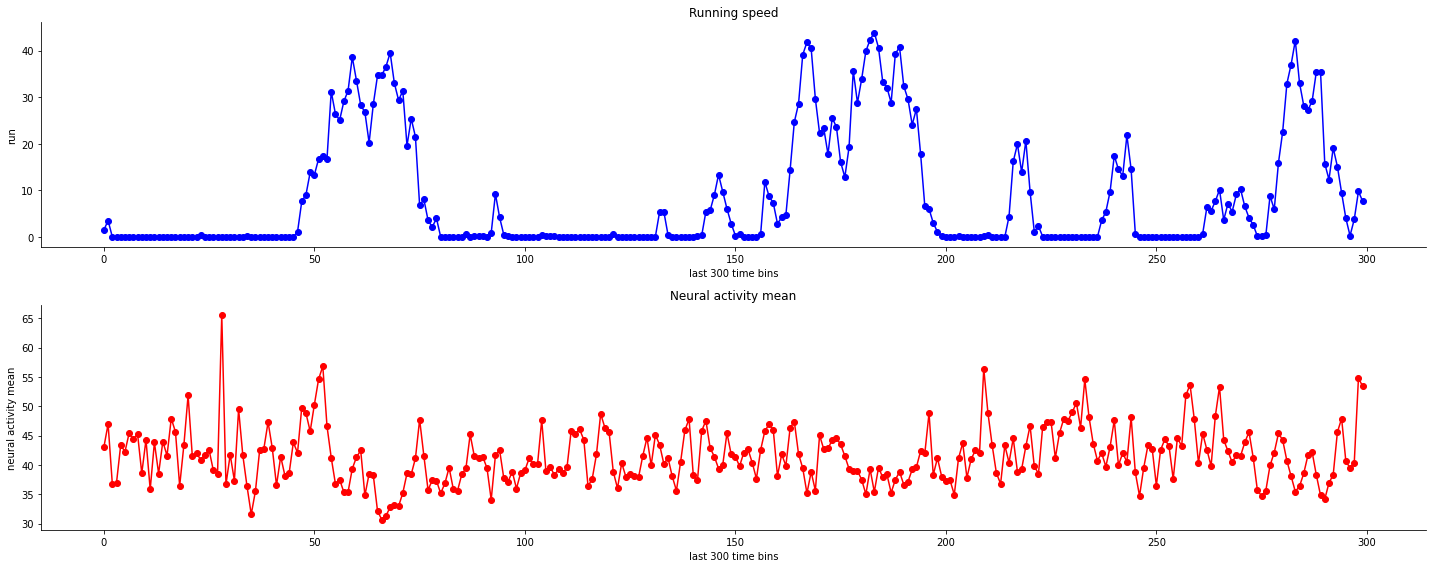

In [160]:
fig = plt.figure(figsize=(20,8))

plt.subplot(2,1,1)
plt.plot(dat['run'][-300:],'-bo')
plt.title('Running speed')
plt.xlabel('last 300 time bins')
plt.ylabel('run')
plt.subplot(2,1,2)
plt.plot(neural_activity_mean[-300:],'-ro')
plt.title('Neural activity mean')
plt.xlabel('last 300 time bins')
plt.ylabel('neural activity mean')


plt.show()

In [127]:
# run and neural activity correlation?

## pupilArea

In [129]:
print(dat['pupilArea'].shape)

(7018, 1)


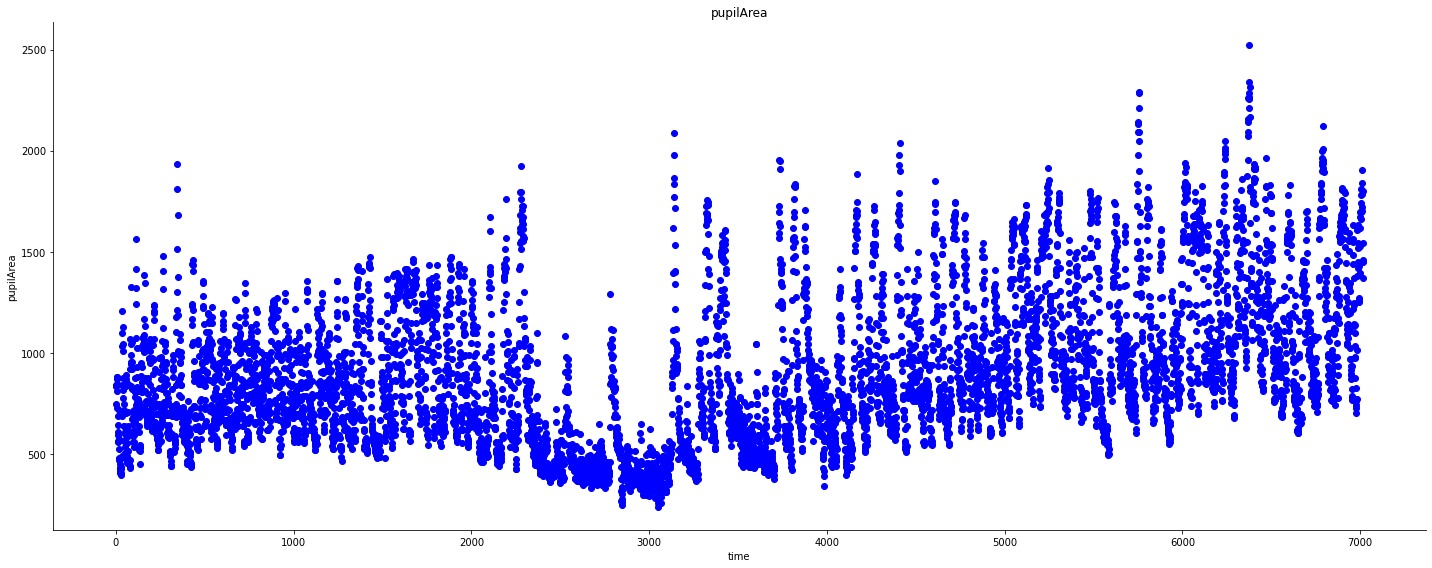

In [133]:
fig = plt.figure(figsize=(20,8))
plt.plot(dat['pupilArea'],'bo')
plt.title('pupilArea')
plt.xlabel('time')
plt.ylabel('pupilArea')

plt.show()

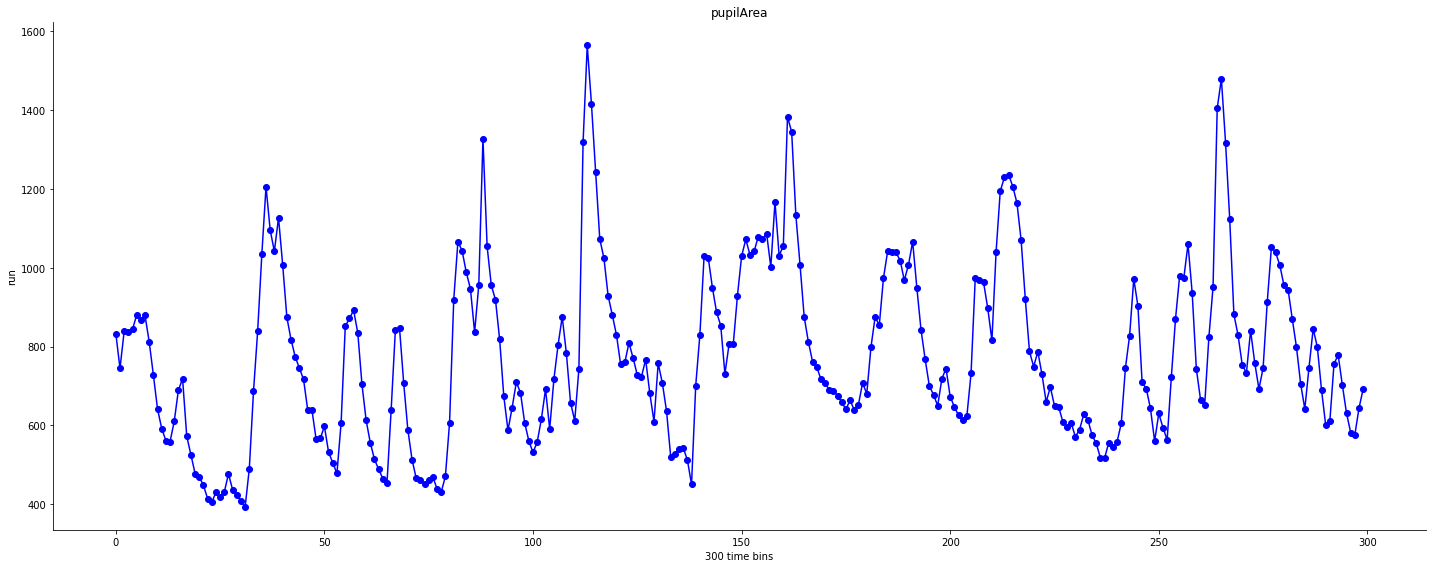

In [134]:
fig = plt.figure(figsize=(20,8))
plt.plot(dat['pupilArea'][:300],'-bo')
plt.title('pupilArea')
plt.xlabel('300 time bins')
plt.ylabel('run')

plt.show()

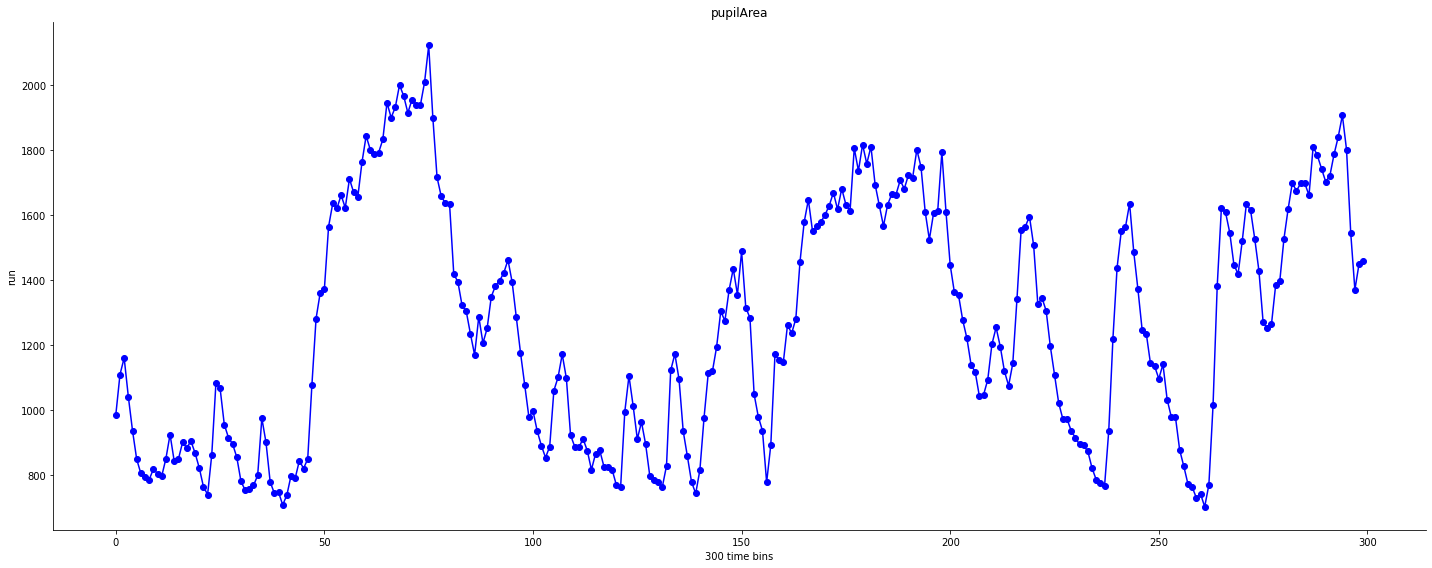

In [135]:
fig = plt.figure(figsize=(20,8))
plt.plot(dat['pupilArea'][-300:],'-bo')
plt.title('pupilArea')
plt.xlabel('300 time bins')
plt.ylabel('run')

plt.show()

## Pupil Area vs neural activity

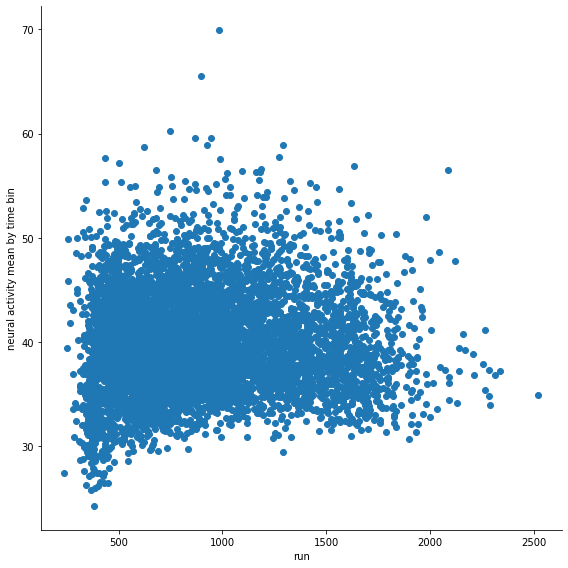

In [136]:
pupilarea = dat['pupilArea']
fig = plt.figure(figsize=(8,8))
plt.plot(pupilarea,neural_activity_mean,'o')
plt.xlabel('run')
plt.ylabel('neural activity mean by time bin')
plt.show()

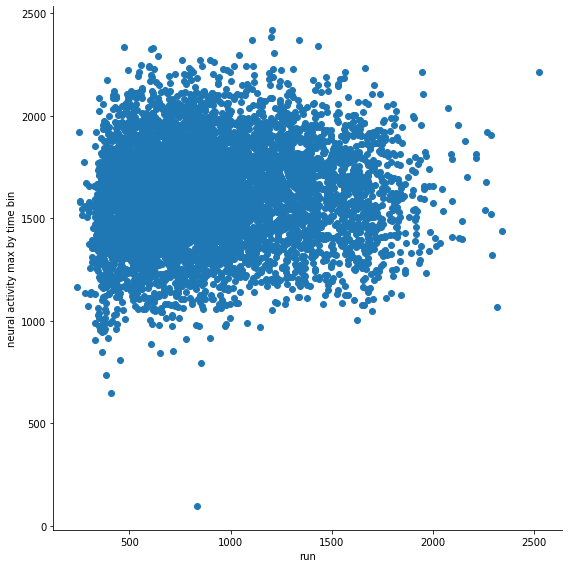

In [137]:
pupilarea = dat['pupilArea']
fig = plt.figure(figsize=(8,8))
plt.plot(pupilarea,neural_activity_max,'o')
plt.xlabel('run')
plt.ylabel('neural activity max by time bin')
plt.show()

## pupilCOM

In [152]:
print(dat['pupilCOM'].shape)

(7018, 2)


In [154]:
dat['pupilCOM'][0]

array([76.04868733, 48.48872503])

In [155]:
x_pupil_com,y_pupil_com = dat['pupilCOM'][:,0],dat['pupilCOM'][:,1]

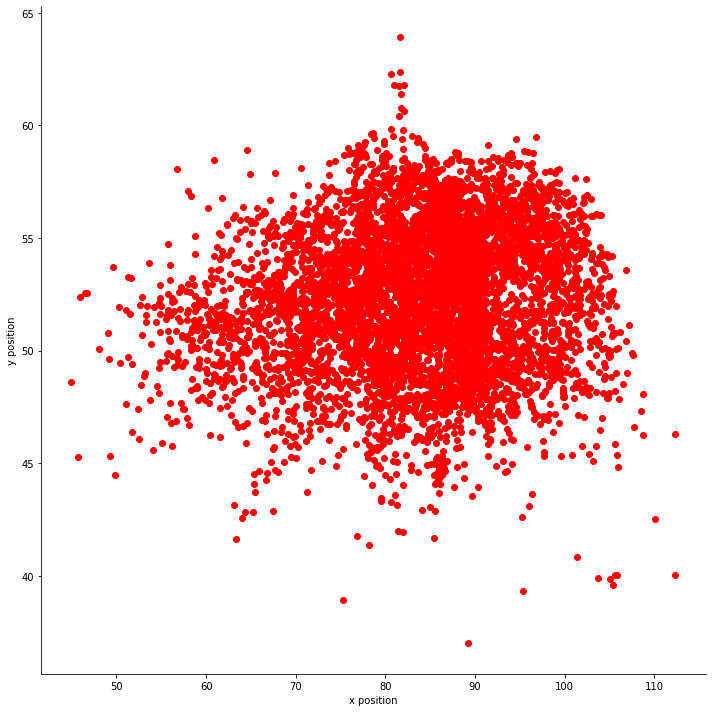

In [158]:
fig = plt.figure(figsize=(10,10))
plt.plot(x_pupil_com,y_pupil_com,'ro')
plt.xlabel('x position')
plt.ylabel('y position')
plt.show()

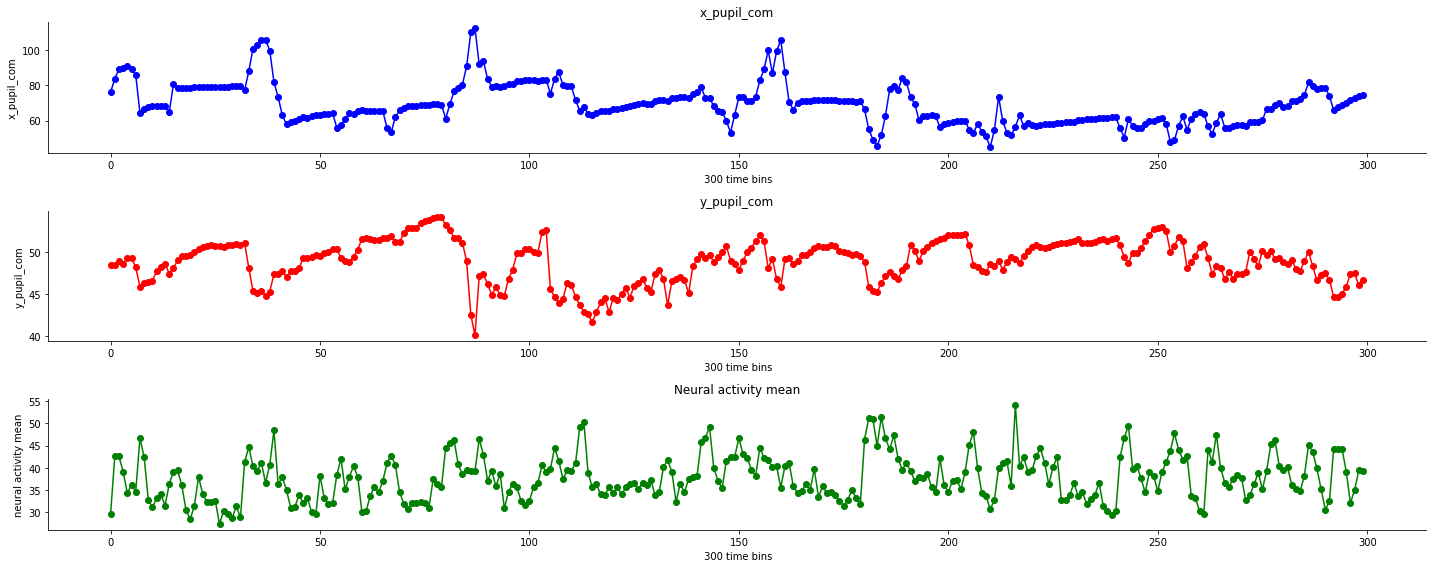

In [164]:
fig = plt.figure(figsize=(20,8))

plt.subplot(3,1,1)
plt.plot(x_pupil_com[:300],'-bo')
plt.title('x_pupil_com')
plt.xlabel(' 300 time bins')
plt.ylabel('x_pupil_com')

plt.subplot(3,1,2)
plt.plot(y_pupil_com[:300],'-ro')
plt.title('y_pupil_com')
plt.xlabel(' 300 time bins')
plt.ylabel('y_pupil_com')

plt.subplot(3,1,3)
plt.plot(neural_activity_mean[:300],'-go')
plt.title('Neural activity mean')
plt.xlabel(' 300 time bins')
plt.ylabel('neural activity mean')


plt.show()

## neural activity vs run speed/ pupil area

In [165]:
run_speed_pupil_area_ratio = dat['run']/dat['pupilArea']
print(run_speed_pupil_area_ratio.shape)

(7018, 1)


Text(0, 0.5, 'neural_activity_mean')

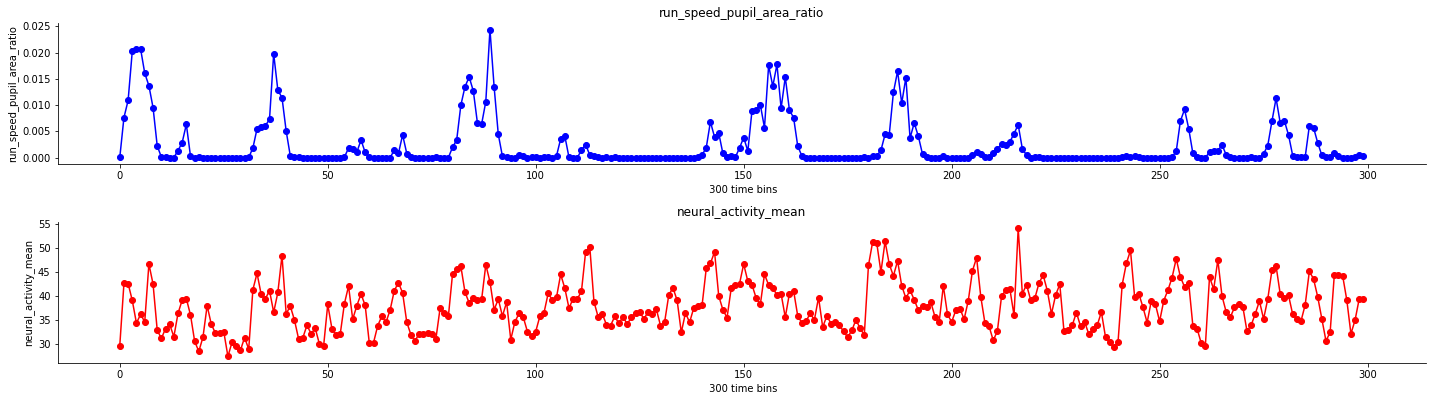

In [167]:
fig = plt.figure(figsize=(20,8))

plt.subplot(3,1,1)
plt.plot(run_speed_pupil_area_ratio[:300],'-bo')
plt.title('run_speed_pupil_area_ratio')
plt.xlabel(' 300 time bins')
plt.ylabel('run_speed_pupil_area_ratio')

plt.subplot(3,1,2)
plt.plot(neural_activity_mean[:300],'-ro')
plt.title('neural_activity_mean')
plt.xlabel(' 300 time bins')
plt.ylabel('neural_activity_mean')

Text(0, 0.5, 'neural_activity_mean')

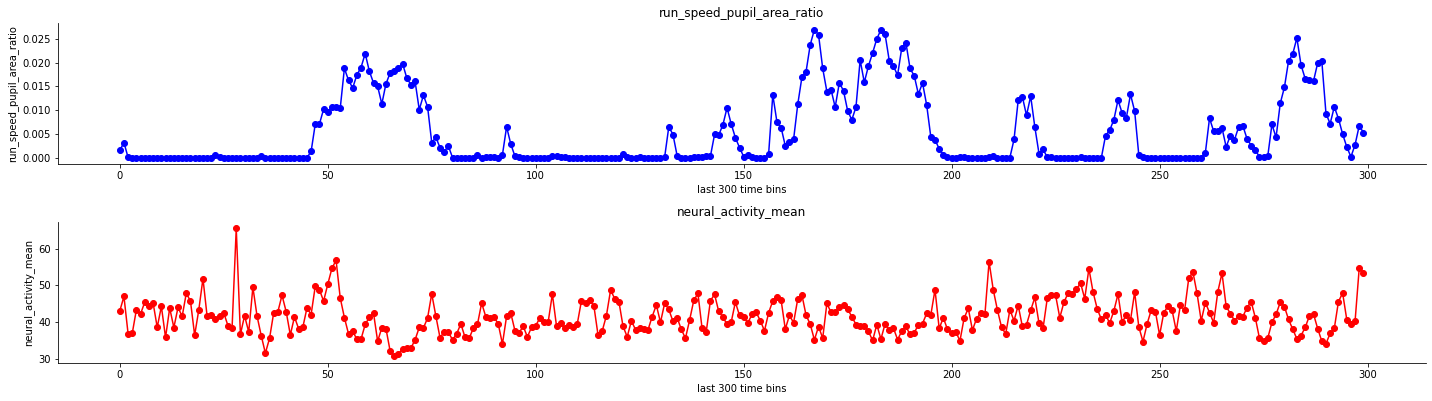

In [169]:
fig = plt.figure(figsize=(20,8))

plt.subplot(3,1,1)
plt.plot(run_speed_pupil_area_ratio[-300:],'-bo')
plt.title('run_speed_pupil_area_ratio')
plt.xlabel('last 300 time bins')
plt.ylabel('run_speed_pupil_area_ratio')

plt.subplot(3,1,2)
plt.plot(neural_activity_mean[-300:],'-ro')
plt.title('neural_activity_mean')
plt.xlabel('last 300 time bins')
plt.ylabel('neural_activity_mean')

## beh_svd_mask

In [172]:
print(dat['beh_svd_mask'].shape)

(240, 320, 1000)


In [173]:
dat['beh_svd_mask'][:,:,0].shape

(240, 320)

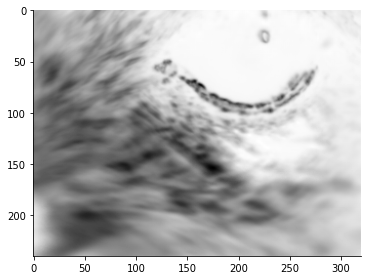

In [174]:
plt.imshow(dat['beh_svd_mask'][:,:,0],cmap='gray')
plt.show()

## beh_svd_time

In [176]:
print(dat['beh_svd_time'].shape)
print(dat['beh_svd_time'][0, :].shape)

(7018, 1000)
(1000,)


In [178]:
dat['beh_svd_time'][:,0].shape

(7018,)

## face reconstruction

In [170]:
face_reconstruction = dat['beh_svd_mask'] @ dat['beh_svd_time'][0, :]

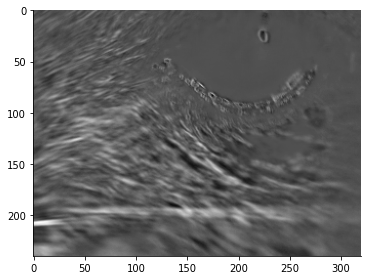

In [171]:
plt.imshow(face_reconstruction,cmap='gray')
plt.show()